<a href="https://colab.research.google.com/github/Jaesu26/Dacon-Basic/blob/main/%EC%87%BC%ED%95%91%EB%AA%B0%ED%8F%89%EC%A0%90-%EB%B6%84%EB%A5%98-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 쇼핑몰 리뷰 평점 분류 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import os, re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [3]:
## Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 24.09 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 688 kB/s 
     |████████████████████████████████| 453 kB 68.1 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-13 14:16:14--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::3403:4be7, 2406:da00:ff00::6b17:d1f5, ...
Connecting to bitbucket.org (b

In [4]:
!pip install customized_konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 881 kB 4.9 MB/s 


In [95]:
SEED = 22
N_FOLD = 5
SAVE_PATH = './weight3'
LEARNING_RATE = 1e-7
EPOCHS = 30
BATCH_SIZE = 64

In [6]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [7]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류/Data'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류/Data


In [8]:
# !unzip -o 'dataset.zip의 사본' ## 현재 디렉토리에 존재하는 zip파일을 현재 디렉토리에 압축해제

In [9]:
%cd  '/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류'

/content/drive/MyDrive/Colab Notebooks/쇼핑몰-평점-분류


In [10]:
df = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
submission = pd.read_csv('./Data/sample_submission.csv')

In [11]:
df.head()

,id,reviews,target
0,0,조아요 처음구입 싸게햇어요,2
1,1,생각보다 잘 안돼요 매지 바른지 하루밖에 안됐는데ㅠㅠ 25천원가량 주고 사기 너무 ...,1
2,2,디자인은괜찮은데 상품이 금이가서 교환했는데 두번째받은상품도 까져있고 안쪽에 금이가져...,2
3,3,기전에 이 제품말고 이마트 트레이더스에서만 팔던 프리미엄 제품을 사용했었습니다. 샘...,2
4,4,튼튼하고 손목을 잘 받쳐주네요~,5


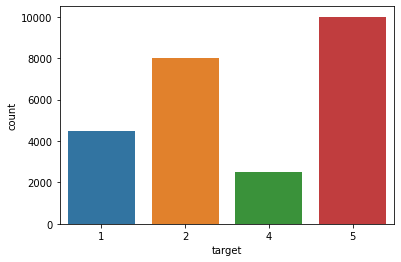

In [12]:
sns.countplot(data=df, x='target')

In [13]:
df['target'].value_counts()

5    10000
2     8000
1     4500
4     2500
Name: target, dtype: int64

## 데이터 전처리

`-` 텐서플로우로 전처리하는게 더 쉬워서 텐서플로우 사용

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Mecab
from ckonlpy.tag import Twitter

- 텍스트 정제

In [15]:
def clean_text(texts): 
    corpus = [] 
    for text in texts: 
        review = re.sub(r'\s+', ' ', text) ## extra space 제거
        review = re.sub(r'^\s+', '', review) ## space from start 제거
        review = re.sub(r'\s+$', '', review) ## space from the end 제거
        corpus.append(review) 

    return corpus

In [16]:
df['clean_reviews'] = clean_text(df['reviews'])
test['clean_reviews'] = clean_text(test['reviews'])

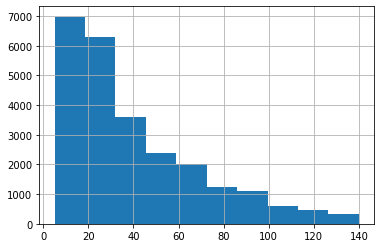

In [17]:
df['clean_reviews'].str.len().hist()

- 토큰화

`-` 참고: https://wikidocs.net/94600

In [18]:
## Twitter를 토크나이저로 사용
twitter = Twitter()

In [19]:
stopwords = ['의', '가', '이', '은', '들', '는', '과', '도', '를', '으로', '에',
             '하다', '을', '이다', '것', '로', '에서', '그', '인', '서', '네요',
             '임', '랑', '게', '요', '에게', '엔']

In [20]:
words = [('강추','Noun'), ('비추','Noun'), ('가성비','Noun'),
         ('재구매','Noun'), ('엉성', 'Noun'), ('핏', 'Noun'), ('타이트','Noun')]

In [21]:
for word in words:
    name, word_type = word
    twitter.add_dictionary(name, word_type)

In [22]:
df['tokenized'] = df['reviews'].apply(lambda x: twitter.morphs(x, norm=True, stem=True))
df['tokenized'] = df['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test['tokenized'] = test['reviews'].apply(lambda x: twitter.morphs(x, norm=True, stem=True))
test['tokenized'] = test['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

- 정수 인코딩

In [36]:
df_train = df['tokenized'].values
df_test= test['tokenized'].values

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train)

`-` 단어 등장횟수 확인

In [38]:
threshold = 2
total_cnt = len(tokenizer.word_index)  ## 단어의 수
rare_cnt = 0  ## 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  ## 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  ## 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

## 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    ## 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' %(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 17222
등장 빈도가 1번 이하인 희귀 단어의 수: 8075
단어 집합에서 희귀 단어의 비율: 46.88770177679712
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.237102377561932


In [39]:
## 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거
## 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print(vocab_size)

9149


`-` 텍스트 시퀀스를 정수 시퀀스로 변환

In [40]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV') 
tokenizer.fit_on_texts(df_train)
df_train = tokenizer.texts_to_sequences(df_train)
df_test = tokenizer.texts_to_sequences(df_test)

- 패딩

리뷰의 최대 길이 : 65
리뷰의 평균 길이 : 14.43832


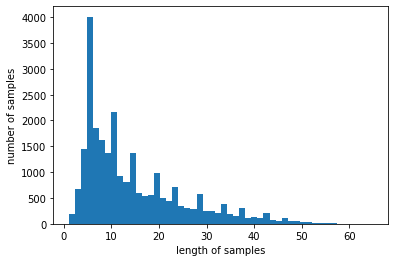

In [41]:
print('리뷰의 최대 길이 :',max(len(review) for review in df_train))
print('리뷰의 평균 길이 :',sum(map(len, df_train)) / len(df_train))
plt.hist([len(review) for review in df_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [42]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (count / len(nested_list))*100))

In [43]:
max_len = 50
below_threshold_len(max_len, df_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.67200000000001


In [44]:
df_train = pad_sequences(df_train, maxlen=max_len)
df_test = pad_sequences(df_test, maxlen=max_len)

## 데이터 셋 및 딥러닝 모델 정의

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from sklearn.model_selection import StratifiedKFold
import gc

- 가중치 저장 폴더 생성

In [46]:
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError as error:
        print(error)

In [47]:
create_folder(SAVE_PATH)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [50]:
## accuracy 계산
def ACCURACY(true, pred):
    return sum(true == pred) / len(true)

In [51]:
def seed_everything(seed: int = 22):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [52]:
seed_everything(SEED) ## 재현을 위한 seed 고정

In [53]:
target = df['target'].copy()
target = target.map({1:0, 2:1, 4:2, 5:3})

- 데이터 셋

In [54]:
class CustomDataset(Dataset):
  
    def __init__(self, X, labels=None, transform=None, target_transform=None):
        self.X = X  ## 시퀀스 매트릭스
        self.labels = labels  ## 라벨
        self.transform = transform  ## X 변환방법
        self.target_transform = target_transform ## 라벨 변환방법
    
    def __getitem__(self, idx):
        data = self.X[idx]
        if self.transform is not None: 
            data = self.transform(data) 
            
        if self.labels is not None:
            label = self.labels[idx]
            if self.target_transform:
                label = self.target_transform(label)             
            return data, label  ## train   
        
        return data  ## test는 라벨이 없다
    
    def __len__(self):
        return self.X.shape[0] ## 데이터 개수 반환

- LSTM

In [97]:
embedding_dim = 128
hidden_size = 256
num_layers = 1
num_classes = 4

In [84]:
class LSTM(nn.Module):

    def __init__(self, embedding_dim, hidden_size, num_layers, num_classes, bidirectional=True):
        super().__init__()  
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.diredction = 2 if bidirectional else 1
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, dropout=0.0, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(self.diredction*hidden_size, num_classes)

    def forward(self, x): 
        ## x의 차원: (배치 크기, 시퀀스 길이, 단어집합의 크기)
        ## 최초의 hidden state와 cell state를 초기화
        x = self.embedding(x)
        h0 = torch.zeros(self.diredction*self.num_layers, x.size(0), self.hidden_size).to(device) ## 은닉층의 차원: (배치 크기, 시퀀스 길이, 은닉층의 노드 개수)
        c0 = torch.zeros(self.diredction*self.num_layers, x.size(0), self.hidden_size).to(device) ## 은닉층과 동일함

        ## LSTM 순전파
        x, _ = self.lstm(x, (h0, c0)) ## output의 차원: (배치 크기, 시퀀스 길이, 은닉층의 노드 개수) 차원의 텐서와 (h_n, c_n) 

        ## 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환
        x = self.fc(x[:, -1, :])
        x = x.squeeze()
        return x

- 가중치 초기화

In [57]:
## Linear layer 가중치 초기화
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        y = m.in_features
        m.weight.data.normal_(0.0, np.sqrt(1 / y))
        m.bias.data.fill_(0)

- 조기 중단

In [58]:
class EarlyStopping:
    ## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='./weight', n_fold=1):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 에폭
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint 저장 경로
                            Default: 'checkpoint.pt'
            n_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.val_acc = None
        self.delta = delta
        self.path = path
        self.n_fold = n_fold

    def __call__(self, model, val_loss, val_acc):

        score = -val_loss ## val_loss는 작을수록 좋다 ## score는 0에 가까울수록 좋다

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, val_acc, model)  
        elif score < self.best_score + self.delta: ## loss가 개선되지 않았을 때
            self.counter += 1 ## 카운팅 +1
            # print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: ## 만약 loss가 개선되지 않은 스탭이 patience보다 크거나 같아진다면 조기중단
                self.early_stop = True
        else: ## loss가 개선됨
            self.best_score = score ## score 갱신
            self.save_checkpoint(val_loss, val_acc, model) ## loss와 model 저장
            self.counter = 0 ## loss가 개선되었으므로 0으로 초기화

    def save_checkpoint(self, val_loss, val_acc, model):
        """validation loss가 감소하면 모델을 저장"""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.5f} -> {val_loss:.5f})  Saving model ...')
        torch.save(model.state_dict(), self.path + f'/best_{self.n_fold}.pt') ## 모델의 계층별 가중치를 지정한 경로에 저장
        self.val_loss_min = val_loss ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.val_acc = val_acc ## 이때의 valid accuracy도 변경해준다

- 스케쥴러

In [59]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    ## 코드: https://github.com/gaussian37/pytorch_deep_learning_models/blob/master/cosine_annealing_with_warmup/cosine_annealing_with_warmup.py
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
            
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## 모델 교차검증

In [60]:
skfold = StratifiedKFold(n_splits=N_FOLD, random_state=SEED, shuffle=True) ## k겹 교차검증

In [88]:
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.025)   ## 손실 함수에 소프트맥스 함수 포함 -> net 내부에서 마지막 활성화함수로 소프트맥스 사용안해도 됨

In [62]:
def train(model: nn.Module, dataloader, optimizer, loss_fn, scheduler=None):
    """dataloader의 데이터를 사용하여 학습된 모델과 epoch 하나당 batch들의 평균 훈련 오차를 반환"""
    model.train() ## 훈련모드
    train_avg_loss = 0 ## 에폭별 배치단위 평균 훈련 오차
    train_total_batch = len(dataloader) ## 배치 크기

    for X, y in dataloader: ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad() ## 그래디언트 초기화
        yhat = model(X) ## y_hat을 구한다
        loss = loss_fn(yhat, y).to(device) ## 오차를 계산 ## train loss
        loss.backward()  ## 미분
        optimizer.step() ## 업데이트
        train_avg_loss += (loss.item() / train_total_batch) ## 각 배치마다 훈련 오차 누적

    ## epoch마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_avg_loss

In [63]:
def evaluate(model: nn.Module, dataloader, loss_fn):
    """dataloader의 데이터를 사용하여 모델에 대한 epoch 하나당 batch들의 평균 평가 오차와 평가 정확도를 반환"""
    valid_avg_acc, valid_avg_loss = 0, 0

    model.eval() ## 평가모드
    with torch.no_grad(): ## 평가할 땐 역전파를 쓸 필요가 없으니까
        for X, y in dataloader: 
            X, y = X.to(device), y.to(device)
            yhat = model(X)
            loss = loss_fn(yhat, y) ## valid loss
            acc = ACCURACY(y.cpu().data.numpy(), yhat.cpu().data.numpy().argmax(-1))       
            valid_avg_acc += (acc * len(y) / len(dataloader.dataset)) ## 각 배치마다 정확도(정답 개수 / 전체 개수)
            valid_avg_loss += loss.item() / len(dataloader) ## 각 배치마다 평가 오차 누적    

    return valid_avg_loss, valid_avg_acc

In [64]:
def show_loss_plot(train_loss: list, valid_loss: list, ax) -> None:
    epochs = len(train_loss)
    ax.set_title('Train Loss and Valid Loss')
    ax.plot(range(1, epochs+1), train_loss, label='Train')
    ax.plot(range(1, epochs+1), valid_loss, label='Valid')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()

- 교차 검증

In [98]:
seed_everything(SEED) ## 정확한 loss 재현을 위함
net_avg_acc = [] ## fold별 valid셋의 평균 정확도
net_avg_loss = [] ## fold별 valid셋의 평균 손실
net_epoch_train_loss = [[] for _ in range(N_FOLD)] ## fold별 train셋의 한 epoch당 valid셋의 배치 평균 손실
net_epoch_valid_loss = [[] for _ in range(N_FOLD)] ## fold별 valid셋의 한 epoch당 valid셋의 배치 평균 손실

for i, (train_idx, valid_idx) in enumerate(skfold.split(df_train, target)):
    gc.collect()
    torch.cuda.empty_cache()
    print(f'{i + 1} / {N_FOLD} Fold Training......')
    X_train, X_valid = df_train[train_idx], df_train[valid_idx] 
    y_train, y_valid = target.iloc[train_idx], target.iloc[valid_idx]
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    y_valid = torch.tensor(y_valid.to_numpy(), dtype=torch.int64) ## target을 텐서로 변환
    
    ## early stopping
    early_stopping = EarlyStopping(patience=5,
                                   verbose=False,
                                   path=SAVE_PATH,
                                   n_fold=i+1) ## 특정 횟수 에폭후에도 valid loss가 작아지지 않으면 조기 중단
    
    ## Linear 모델
    net = LSTM(embedding_dim, hidden_size, num_layers, num_classes, bidirectional=True).to(device) 
    net.apply(init_weights) ## Linear layer 가중치 초기화
    
    ## Dataset, Dataloader
    train_dataset = CustomDataset(X_train, y_train)
    valid_dataset = CustomDataset(X_valid, y_valid)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

    ## optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE) ## 옵티마이저에 최적화할 파라미터와 학습률 전달
    
    ## scheduler
    scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=20, T_mult=1, eta_max=1e-3, T_up=5, gamma=0.1)
    
    ## fold별로 모델 학습
    for epoch in tqdm(range(EPOCHS)): ## (배치사이즈 * 에폭)만큼 훈련시킴
        net, train_avg_loss = train(net, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
        valid_avg_loss, valid_avg_acc = evaluate(net, valid_dataloader, loss_fn)  ## 모델 평가
        net_epoch_train_loss[i].append(train_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 훈련 오차
        net_epoch_valid_loss[i].append(valid_avg_loss) ## i번째 fold의 에폭 하나당 평균 배치 평가 오차

        if epoch % 10 == 0 or epoch == EPOCHS - 1: 
            ## 10의 배수값을 가지는 에폭마다 평균 배치 훈련 오차와 평가 오차 출력
            print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            
        ## epoch마다 early stopping 실행
        early_stopping(net, valid_avg_loss, valid_avg_acc) ## __call__ function
        if early_stopping.early_stop: ## early_stop이 true이면
            if epoch % 10 != 0 and epoch != EPOCHS - 1:
                print('[Epoch: {:>3}] train loss = {:>.5}  valid loss = {:>.5}'.format(epoch + 1, train_avg_loss, valid_avg_loss)) 
            print('Early stopping!')
            break 

    net_avg_acc.append(early_stopping.val_acc) ## fold별 loss가 가장 작은 모델의 정확도
    net_avg_loss.append(early_stopping.val_loss_min) ## fold별 loss가 가장 작은 모델의 손실
    
    ## fold별 평가 루프 종료시 가장 작은 loss와 이때의 accuracy를 출력
    print(f'{i + 1} Fold -> Best Valid Loss: {early_stopping.val_loss_min:.4f}  Best Valid Accuracy: {early_stopping.val_acc:.4f}\n\n')
    
## 마지막으로 폴드별 가장 loss가 작은 모델들의 평균 정확도와 평균 손실을 출력
print(f'{skfold.n_splits} Fold Mean Valid Accuracy: {np.mean(net_avg_acc):.4f}')
print(f'{skfold.n_splits} Fold Mean Valid Loss: {np.mean(net_avg_loss):.4f}')                

1 / 5 Fold Training......


  3%|▎         | 1/30 [00:03<01:41,  3.51s/it]

[Epoch:   1] train loss = 1.3799  valid loss = 1.3791


 30%|███       | 9/30 [00:34<01:20,  3.82s/it]

[Epoch:  10] train loss = 0.26642  valid loss = 1.3877
Early stopping!
1 Fold -> Best Valid Loss: 0.9044  Best Valid Accuracy: 0.6428


2 / 5 Fold Training......



  3%|▎         | 1/30 [00:03<01:40,  3.47s/it]

[Epoch:   1] train loss = 1.3917  valid loss = 1.3909


 27%|██▋       | 8/30 [00:31<01:26,  3.95s/it]

[Epoch:   9] train loss = 0.40256  valid loss = 1.1799
Early stopping!
2 Fold -> Best Valid Loss: 0.8924  Best Valid Accuracy: 0.6400


3 / 5 Fold Training......



  3%|▎         | 1/30 [00:03<01:39,  3.42s/it]

[Epoch:   1] train loss = 1.3878  valid loss = 1.386


 30%|███       | 9/30 [00:34<01:20,  3.84s/it]

[Epoch:  10] train loss = 0.26595  valid loss = 1.4055
Early stopping!
3 Fold -> Best Valid Loss: 0.9026  Best Valid Accuracy: 0.6360


4 / 5 Fold Training......



  3%|▎         | 1/30 [00:03<01:39,  3.42s/it]

[Epoch:   1] train loss = 1.3883  valid loss = 1.3851


 27%|██▋       | 8/30 [00:30<01:24,  3.85s/it]

[Epoch:   9] train loss = 0.39865  valid loss = 1.1618
Early stopping!
4 Fold -> Best Valid Loss: 0.9011  Best Valid Accuracy: 0.6350




5 / 5 Fold Training......


  3%|▎         | 1/30 [00:03<01:39,  3.43s/it]

[Epoch:   1] train loss = 1.3843  valid loss = 1.3846


 30%|███       | 9/30 [00:34<01:19,  3.79s/it]

[Epoch:  10] train loss = 0.26669  valid loss = 1.3259
Early stopping!
5 Fold -> Best Valid Loss: 0.8834  Best Valid Accuracy: 0.6472


5 Fold Mean Valid Accuracy: 0.6402
5 Fold Mean Valid Loss: 0.8968


- epoch에 따른 loss 변화

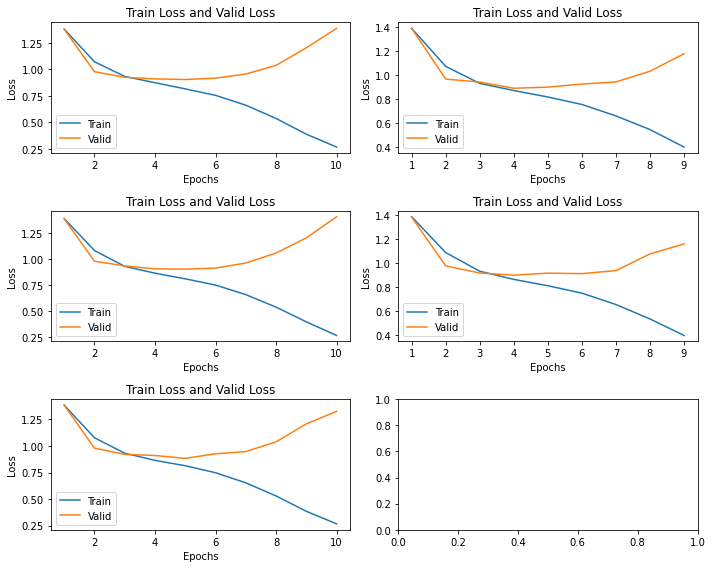

In [99]:
## fold별 epoch당 train loss와 valid loss의 변화
fig ,axs = plt.subplots(3, 2, figsize=(10, 8))
for i, ax in enumerate(axs.flatten()):
    try:
        show_loss_plot(net_epoch_train_loss[i], net_epoch_valid_loss[i], ax)
    except:
        pass
fig.tight_layout()

## test 예측

`-` softmax function을 취하면 4개의 원소 중 최대값의 인덱스 번호가 최종 예측값이 된다

In [70]:
def predict(model: nn.Module, dataloader, weight_save_path, is_prob=False) -> np.array:
    model = model.to(device)
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), num_classes)) ## test예측값

    for weight in weight_path_list :
        model.load_state_dict(torch.load(weight))
        model.eval()
        probs = None
        
        with torch.no_grad(): 
            for test_batch in dataloader:
                test_batch = test_batch.to(device)
                outputs = model(test_batch).cpu().numpy()
                if probs is None:
                    probs = outputs
                else:
                    probs = np.concatenate([probs, outputs])

        test_probs += (probs / N_FOLD)
    _, test_preds = torch.max(torch.tensor(test_probs), dim=1) ## 최대값과 인덱스를 반환

    if is_prob:
        return test_probs ## 각 컬럼별 확률값
    return test_preds ## 라벨값

In [71]:
def softmax(arr):
    new_arr = np.exp(arr) / (np.exp(arr[:, 0]).reshape(-1, 1) + np.exp(arr[:, 1]).reshape(-1, 1) + np.exp(arr[:, 2]).reshape(-1, 1) + np.exp(arr[:, 3]).reshape(-1, 1))
    return new_arr

In [100]:
net = LSTM(embedding_dim, hidden_size, num_layers, num_classes, bidirectional=True).to(device) 

In [101]:
test_dataset = CustomDataset(df_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

`-` 가장 확률이 높은 평점이 1 or 2 인지 4 or 5 인지 확인한다

`-` 만약 1 or 2일 확률이 더 높다면 사전 확률을 고려하여 1일 확률이 0.36 이상이면 1로 그 외에는 2로 맵핑한다

`-` 만약 4 or 5일 확률이 더 높다면 사전 확률을 고려하여 4일 확률이 0.2 이상이면 4로 그 외에는 5로 맵핑한다

`-` 단, 표본공간은 그대로 둔다

`-` 단순히 사전 확률으로만 판단하지 않고 적당한 상수를 곱해주어 비교했다

`-` 이유는 적당한 상수를 곱해주었을 때 성능이 더 잘 나왔기 때문이다

- why?

`-` 내 생각, 틀릴 확률 80% 정도

`-` 정확하게 하려면, 예컨대 1 or 2일 확률이 더 높다면 부정적인 리뷰를 다시 예측하여 1점일 확률과 2점일 확률을 구하고 사전 확률을 이용하여 판단해야 한다 

`-` 그런데 리뷰를 다시 예측하지 않으므로 단순히 사전 확률만 사용해 1점일 확률이 0.2보다 높은지를 판단하는 것은 리뷰에 평점을 매기기 애매할수록 주된 라벨 (2 or 5)일 확률이 낮으니까 (이는 1 or 4일 확률이 높음을 의미함) 기존에 의도한 사전 확률보다 1 or 4가 선택될 가능성이 과대 추정된다고 생각한다

`-` 그런데 성능이 오히려 떨어졌다 (delta 값을 잘 설정해야 할 듯)

In [74]:
def get_label(probs, delta=0.1):
    preds = []
    for prob in probs:
        max_idx = np.argmax(prob)
        if max_idx >= 2: ## 평점은 4 or 5일 확률이 1 or 2일 확률보다 더 높다
            if prob[2] > 0.2 * (1 + delta):
                preds.append(4)
            else:
                preds.append(5)
        else:
            if prob[0] > 0.36 * (1 + delta):
                preds.append(1)
            else:
                preds.append(2)
    return preds

In [102]:
preds = predict(net, test_dataloader, SAVE_PATH, is_prob=False)

In [103]:
submission['target'] = preds
submission['target'] = submission['target'].map({0:1, 1:2, 2:4, 3:5})
submission.head()

,id,target
0,0,2
1,1,1
2,2,5
3,3,2
4,4,1


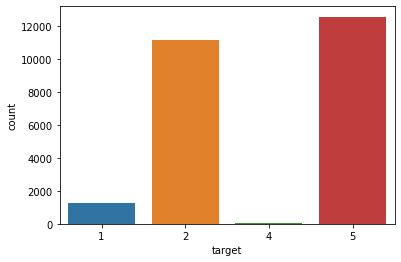

In [104]:
sns.countplot(data=submission, x='target')

In [106]:
# submission.to_csv('./Data/submission_RNN2.csv', index=False)